In [28]:
import json
import keras
import tensorflow_probability as tfp
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
from keras import callbacks
import pickle

In [ ]:
f = open('mpd.slice.0-999.json')
file = json.load(f)

In [ ]:
playlists = []

for p in file['playlists']:
  playlist = []
  for track in p['tracks']:
    playlist.append(track['artist_name'] + " - " + track['track_name'])
  playlists.append(playlist)

In [ ]:
i = 0
track_dict = {}
for p in playlists:
  for t in p:
    if t not in track_dict.keys():
      track_dict[t] = i
      i += 1

dict_size = i

In [ ]:
playlists_tokenized = []

for p in playlists:
  playlist = []
  for t in p:
    playlist.append(track_dict[t])
  playlists_tokenized.append(playlist)

In [ ]:
n_steps = 1
n_features = 1

In [ ]:
data = []

for p in playlists_tokenized:
  for i in range(len(p) - 1):
    data.append([p[i], p[i+1]])

df = pd.DataFrame(data, columns = ['Song', 'Next'])

In [36]:
def run_experiment(model, loss, X_train, X_test, y_train, y_test):

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError(), 'accuracy'],
    )
    callback = callbacks.EarlyStopping(monitor='val_acc', patience=5)
    print("Start training the model...")
    history = model.fit(x=X_train, y=y_train, epochs=10, validation_data=(X_test, y_test))
    print("Model training finished.")
    #print(model.metrics_names)
    _, rmse, _ = model.evaluate(x=X_train, y=y_train, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse, _ = model.evaluate(x=X_test, y=y_test, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")
    return history

# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

def create_probablistic_bnn_model(train_size):
    inputs = keras.layers.Input(
            name="Song", shape=(1,))
    #features = keras.layers.concatenate(inputs)
    features = keras.layers.BatchNormalization()(inputs)
    
    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in [8, 8]:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # Create a probabilisticå output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = keras.layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["Song"], df["Next"], test_size=0.20, random_state=42)

In [ ]:
y_test = tf.cast(y_test, tf.float32)
y_train = tf.cast(y_train, tf.float32)

In [37]:
prob_bnn_model = create_probablistic_bnn_model(len(X_train))
history = run_experiment(prob_bnn_model, negative_loglikelihood, X_train, X_test, y_train, y_test)

AttributeError: ignored

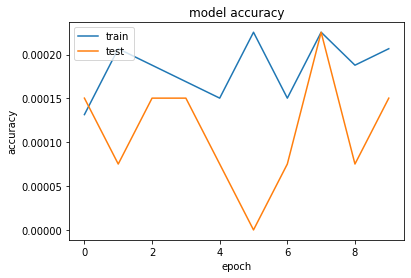

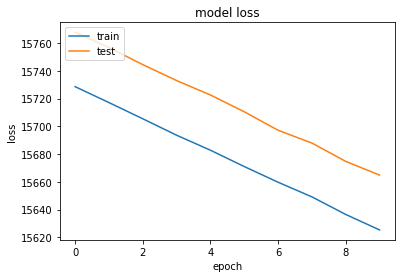

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
pickle.dump(prob_bnn_model, open('model.pkl', 'wb'))

AttributeError: ignored

In [39]:
keras.models.save_model(prob_bnn_model, 'model')

AttributeError: ignored

# Test


In [ ]:
model = tf.keras.Sequential()
model.add(keras.layers.LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(keras.layers.Dense(1))

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=[keras.metrics.RootMeanSquaredError(), 'accuracy'],
)

In [ ]:
history = model.fit(X_train, y_train, epochs=4, verbose=1, validation_data=(X_test, y_test))

Epoch 1/4
1663/1663 [==============================] - 10s 5ms/step - loss: 85413472.0000 - root_mean_squared_error: 9241.9414 - accuracy: 2.0676e-04 - val_loss: 83032800.0000 - val_root_mean_squared_error: 9112.2334 - val_accuracy: 1.5036e-04
Epoch 2/4
1663/1663 [==============================] - 9s 5ms/step - loss: 84114336.0000 - root_mean_squared_error: 9171.3867 - accuracy: 2.0676e-04 - val_loss: 83879328.0000 - val_root_mean_squared_error: 9158.5654 - val_accuracy: 1.5036e-04
Epoch 3/4
1663/1663 [==============================] - 8s 5ms/step - loss: 83775688.0000 - root_mean_squared_error: 9152.9062 - accuracy: 2.0676e-04 - val_loss: 83801208.0000 - val_root_mean_squared_error: 9154.2998 - val_accuracy: 1.5036e-04
Epoch 4/4
1663/1663 [==============================] - 8s 5ms/step - loss: 83626400.0000 - root_mean_squared_error: 9144.7471 - accuracy: 2.0676e-04 - val_loss: 82807800.0000 - val_root_mean_squared_error: 9099.8789 - val_accuracy: 1.5036e-04
